<a href="https://colab.research.google.com/github/Mrezakhodashenas/PhD-NN/blob/main/one_Hidden_layer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%reset -f


In [2]:
# 1. Learning how spiking neurons are implemented as a recurrent network
# 2. Understanding backpropagation through time, and the associated challenges in SNNs such as the non-differentiability of spikes
# 3. Training a fully-connected network on the static MNIST dataset

!pip install snntorch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 2.3 MB/s eta 0:00:00


In [3]:
!pip install Graphviz


In [4]:
import pickle
import os
import sys
import time
import datetime
import json
import random
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools
import math

from torchvision import utils as utls
from snntorch import utils

from snntorch._neurons.alpha import Alpha


In [5]:
# lif1 = snn.Leaky(beta=0.9)
# lif1 = snn.Lapicque(beta=0.9, R=5.1, C=5e-3, time_step=1e-3, threshold=0.5)
# lif1 = snn.Synaptic(alpha=alpha, beta=beta, threshold, reset_mechanism)    # alpha = 0.9 , beta = 0.8


In [6]:


# dataloader arguments
batch_size = 128
data_path='/data/mnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [7]:
# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 196272010.86it/s]

Extracting /data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /data/mnist/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 87525790.34it/s]


Extracting /data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /data/mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 138110661.94it/s]

Extracting /data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/mnist/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 16580094.66it/s]


Extracting /data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/mnist/MNIST/raw



In [8]:
# Create DataLoaders
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)


In [9]:
#                   /////////////////////// Network Architecture
num_inputs = 28*28
num_hidden = 1000
# num_hidden = 1000
num_outputs = 10

# Temporal Dynamics
num_steps = 25
# Rsyn=1
# Rmem=1
# Cmem=5e-3
# Csyn=5e-3
alpha=0.9
beta = 0.8

R1=0.1
R2=1
C=1e-3
time_step=1e-3
threshold=1

In [11]:
# ///////////////////////////////// / ////  Define Network

class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # # # ------------------ Initialize layers

        # self.fc1 = nn.Linear(num_inputs, num_hidden)
        # self.lif1 = snn.Leaky(beta=beta, threshold=threshold)
        # self.fc2 = nn.Linear(num_hidden, num_outputs)
        # self.lif2 = snn.Leaky(beta=beta, threshold=threshold)
        # # ----------
    # #  --------------------------------------------Synaptic & Lapicque ------------------------------------- #
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Lapicque(R=R1, C=C, threshold=threshold, time_step=time_step)
        # self.lif1 = snn.Synaptic(alpha, beta, threshold=threshold)    # alpha = 0.9 , beta = 0.8
        # self.lif1 = Alpha(alpha=alpha, beta=beta, threshold=threshold)

        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Lapicque(R=R2, C=C, threshold=threshold, time_step=time_step)
        # self.lif2 = Alpha(alpha=alpha, beta=beta, threshold=threshold)

        # self.lif2 = snn.Leaky(beta=beta, threshold=threshold)

    # #  ------------------------------------------------------------------------------------------ #


    def forward(self, x):

        # # -------Initialize hidden states at t=0
        # mem1 = self.lif1.init_leaky()
        # mem2 = self.lif2.init_leaky()

  #  #  --------------------------------------------Synaptic------------------------------------- #
        # syn, mem1 = self.lif1.init_synaptic()
        mem1 = self.lif1.init_lapicque()

        mem2 = self.lif2.init_lapicque()
    # #  ------------------------------------------------------------------------------------------ #


        # Record the final layer
        cur1_rec = []

        # syn_rec = []
        mem1_rec = []
        spk1_rec = []

        cur2_rec = []
        spk2_rec = []
        mem2_rec = []
  #  ------------------------------------------------------------------------------------------ #

# # /////////////////////////////////////////////////////////
#         for step in range(num_steps):
#             cur1 = self.fc1(x)
#             spk1, mem1 = self.lif1(cur1, mem1)
#             cur2 = self.fc2(spk1)
#             spk2, mem2 = self.lif2(cur2, mem2)

#             mem1_rec.append(mem1)
#             cur2_rec.append(cur2)
#             spk1_rec.append(spk1)
#             spk2_rec.append(spk2)
#             mem2_rec.append(mem2)
#         # return torch.stack(spk1_rec, dim=0), torch.stack(mem1_rec, dim=0), torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)
#         return torch.stack(spk1_rec, dim=0), torch.stack(mem1_rec, dim=0), torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

# //////////////////////////////////////////////////////// synaptic///////////////////////////////
        for step in range(num_steps):
            cur1 = self.fc1(x)
            # spk1, syn, mem1 = self.lif1(cur1, syn, mem1)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)


            cur1_rec.append(cur1)
            # syn_rec.append(syn)
            mem1_rec.append(mem1)
            spk1_rec.append(spk1)
            cur2_rec.append(cur2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)
        # return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)
        # return torch.stack(syn_rec, dim=0), torch.stack(spk1_rec, dim=0), torch.stack(mem1_rec, dim=0), torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)
        return torch.stack(spk1_rec, dim=0), torch.stack(mem1_rec, dim=0), torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

# /////////////////////////////////////////////////////////


#------------------------------ For Synaptic current
# for step in range(num_steps):
#   spk_out, syn, mem = lif1(spk_in[step], syn, mem)
#   spk_rec.append(spk_out)
#   syn_rec.append(syn)
#   mem_rec.append(mem)

# convert lists to tensors
# spk1_rec = torch.stack(spk1_rec)
# syn_rec = torch.stack(syn_rec)
# mem_rec = torch.stack(mem_rec)

# plot_spk_cur_mem_spk(spk_in, syn_rec, mem_rec, spk_rec,
#                      "Synaptic Conductance-based Neuron Model With Input Spikes")
#------------------------------


# plot_snn_spikes(spk_in, spk1_rec, spk2_rec, "Fully Connected Spiking Neural Network with MNIST data")


# Load the network onto CUDA if available
net = Net().to(device)


In [ ]:
# import networkx as nx
# import matplotlib.pyplot as plt

# # Create a directed graph
# G = nx.DiGraph()


# # Add nodes
# G.add_node('Input Layer', pos=(0.5, 1.2))
# G.add_node('Hidden Layer (Lapicque)', pos=(1, 1))
# G.add_node('Output Layer (Lapicque)', pos=(1.5, 1.2))

# # Add edges
# G.add_edge('Input Layer', 'Hidden Layer (Lapicque)', label='Linear')
# G.add_edge('Hidden Layer (Lapicque)', 'Output Layer (Lapicque)', label='Linear')

# # Set positions for the nodes
# pos = nx.get_node_attributes(G, 'pos')

# # Draw the graph
# plt.figure(figsize=(10, 3))
# nx.draw(G, pos, with_labels=True, node_size=1000, node_color='lightblue', font_size=8, font_weight='bold')
# edge_labels = nx.get_edge_attributes(G, 'label')
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
# plt.title('Neural Network Architecture')
# plt.axis('off')
# plt.show()


In [ ]:
# import networkx as nx
# import matplotlib.pyplot as plt

# # Create a directed graph
# G = nx.DiGraph()

# # Define the number of nodes in each layer
# num_inputs = 28 * 28
# num_hidden = 1000
# num_outputs = 10

# # Add nodes with labels
# G.add_node(f'Input Layer\n({num_inputs} nodes)', pos=(0.9, 1.2))
# G.add_node(f'Hidden Layer (Lapicque)\n({num_hidden} nodes)', pos=(1, 1))
# G.add_node(f'Output Layer (Lapicque)\n({num_outputs} nodes)', pos=(1.1, 1.2))

# # Add edges
# G.add_edge(f'Input Layer\n({num_inputs} nodes)', f'Hidden Layer (Lapicque)\n({num_hidden} nodes)', label='Linear')
# G.add_edge(f'Hidden Layer (Lapicque)\n({num_hidden} nodes)', f'Output Layer (Lapicque)\n({num_outputs} nodes)', label='Linear')

# # Set positions for the nodes
# pos = nx.get_node_attributes(G, 'pos')

# # Draw the graph
# plt.figure(figsize=(4, 3))
# nx.draw(G, pos, with_labels=True, node_size=1000, node_color='lightblue', font_size=7, font_weight='bold')
# edge_labels = nx.get_edge_attributes(G, 'label')
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
# plt.title('Neural Network Architecture')
# plt.axis('off')
# plt.show()


In [ ]:
# #----------------------------------------  Training the SNN -------------------------------------
# # ------------ 7.1 Accuracy Metric
# # Below is a function that takes a batch of data, counts up all the spikes from each neuron (i.e., a rate code over the simulation time),
# #  and compares the index of the highest count with the actual target. If they match, then the network correctly predicted the target.

# # pass data into the network, sum the spikes over time
# # and compare the neuron with the highest number of spikes
# # with the target

# def print_batch_accuracy(data, targets, train=False):
#     spk1_rec, mem1_rec, output, _ = net(data.view(batch_size, -1))
#     # syn_rec, spk1_rec, mem1_rec, output, _ = net(data.view(batch_size, -1))
#     _, idx = output.sum(dim=0).max(1)   # determine the predicted labels for the input data.
#     acc = np.mean((targets == idx).detach().cpu().numpy())   # calculates the accuracy by comparing the predicted labels (idx) with the target labels (targets)

#     if train:
#         print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
#     else:
#         print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

# def train_printer(
#     data, targets, epoch,
#     counter, iter_counter,
#         loss_hist, test_loss_hist, test_data, test_targets):
#     print(f"Epoch {epoch}, Iteration {iter_counter}")
#     print(f"Train Set Loss: {loss_hist[counter]:.2f}")
#     print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
#     print_batch_accuracy(data, targets, train=True)
#     print_batch_accuracy(test_data, test_targets, train=False)
#     print("\n")

In [12]:

# Function to calculate accuracy given a batch of data and targets
def calculate_accuracy(data, targets):
    spk1_rec, mem1_rec, output, _ = net(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    print(idx.size())  # prints the size of idx tensor
    print(idx.shape)
    acc = np.mean((targets == idx).detach().cpu().numpy())
    return acc

def print_batch_accuracy(data, targets, train=False):
    acc = calculate_accuracy(data, targets)
    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

# Function to print training information
def train_printer(
    data, targets, epoch, counter, iter_counter,
    loss_hist, test_loss_hist, test_data, test_targets
):
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

In [13]:
# Loss Definition
# The nn.CrossEntropyLoss function in PyTorch automatically handles taking the softmax of the output layer as well as generating a loss at the output.
loss = nn.CrossEntropyLoss()

# Optimizer
# Adam is a robust optimizer that performs well on recurrent networks, so let's use that with a learning rate of 5×10−4
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

In [14]:
# One Iteration of Training

# Take the first batch of data and load it onto CUDA if available.
data, targets = next(iter(train_loader))
data = data.to(device)
targets = targets.to(device)


# # Flatten the input data to a vector of size 784 and pass it into the network.

spk1_rec, mem1_rec, spk2_rec, mem2_rec = net(data.view(batch_size, -1))

# syn_rec, spk1_rec, mem1_rec, spk2_rec, mem2_rec = net(data.view(batch_size, -1))

# print('syn_rec.size: ', syn_rec.size())
print('spk1_rec.size: ', spk1_rec.size())
print('mem1_rec.size: ', mem1_rec.size())
print('spk2_rec.size: ', spk2_rec.size())
print('mem2_rec.size: ', mem2_rec.size())


spk1_rec.size:  torch.Size([25, 128, 1000])
mem1_rec.size:  torch.Size([25, 128, 1000])
spk2_rec.size:  torch.Size([25, 128, 10])
mem2_rec.size:  torch.Size([25, 128, 10])


In [15]:
# The recording of the membrane potential is taken across:
# 25 time steps
# 128 samples of data
# 10 outp|ut neurons
# We wish to calculate the loss at every time step, and sum these up together, as per Equation (10):

# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every step
for step in range(num_steps):
  loss_val += loss(mem2_rec[step], targets)

print(f"Training loss: {loss_val.item():.3f}")

Training loss: 59.081


In [16]:
print_batch_accuracy(data, targets, train=True)

torch.Size([128])
torch.Size([128])
Train set accuracy for a single minibatch: 7.81%


In [17]:
# A single weight update is applied to the network as follows:

# clear previously stored gradients
optimizer.zero_grad()

# calculate the gradients
loss_val.backward()

# weight update
optimizer.step()

In [18]:
# # calculate new network outputs using the same data
# spk_rec, mem_rec = net(data.view(batch_size, -1))
# syn_rec, spk1_rec, mem1_rec, spk2_rec, mem2_rec = net(data.view(batch_size, -1))
# spk2_rec, mem2_rec = net(data.view(batch_size, -1))

# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every step
for step in range(num_steps):
  loss_val += loss(mem2_rec[step], targets)

print(f"Training loss: {loss_val.item():.3f}")
print_batch_accuracy(data, targets, train=True)


Training loss: 59.081
torch.Size([128])
torch.Size([128])
Train set accuracy for a single minibatch: 7.81%


In [ ]:
# start_time = datetime.datetime.now()
# num_epochs = 1
# loss_hist = []
# test_loss_hist = []
# counter = 0
# avg_loss_hist = []  # List to store average loss values
# avg_test_loss_hist = []

# # Create a directory to save the images
# os.makedirs('figures/testing', exist_ok=True)


# # Outer training loop
# for epoch in range(num_epochs):
#     iter_counter = 0
#     train_batch = iter(train_loader)

#     # Minibatch training loop
#     for data, targets in train_batch:
#         data = data.to(device)
#         targets = targets.to(device)

#         # forward pass
#         net.train()
#         # syn_rec, spk1_rec, mem1_rec, spk2_rec, mem2_rec = net(data.view(batch_size, -1))
#         spk1_rec, mem1_rec, spk2_rec, mem2_rec = net(data.view(batch_size, -1))


#         # initialize the loss & sum over time
#         loss_val = torch.zeros((1), dtype=dtype, device=device)
#         for step in range(num_steps):
#             loss_val += loss(mem2_rec[step], targets)

#         # Gradient calculation + weight update
#         optimizer.zero_grad()
#         loss_val.backward()
#         optimizer.step()

#         # Store loss history for future plotting
#         loss_hist.append(loss_val.item())

#         # Test set
#         with torch.no_grad():
#             net.eval()
#             test_data, test_targets = next(iter(test_loader))
#             test_data = test_data.to(device)
#             test_targets = test_targets.to(device)

#             # # Test set forward pass
#             # test_syn, test_spk1, test_mem1, test_spk2, test_mem2 =  net(test_data.view(batch_size, -1))
#             test_spk1, test_mem1, test_spk2, test_mem2 =  net(test_data.view(batch_size, -1))

#             # Test set loss
#             test_loss = torch.zeros((1), dtype=dtype, device=device)
#             for step in range(num_steps):
#                 test_loss += loss(test_mem2[step], test_targets)
#             test_loss_hist.append(test_loss.item())

#             # Print train/test loss/accuracy
#             if counter % 50 == 0:
#                 train_printer(
#                     data, targets, epoch,
#                     counter, iter_counter,
#                     loss_hist, test_loss_hist,
#                     test_data, test_targets)
#                 # Save the image
#                 # utls.save_image((data  +1)/2, f'figures/training/epoch{epoch}_batch{counter}_inputs.png')
#                 utls.save_image((test_data + 1) / 2, f'figures/testing/epoch{epoch}_batch{counter}_inputs.png')

#             counter += 1
#             iter_counter +=1
#         # Calculate average loss for the current iteration
#         avg_loss = sum(loss_hist[-num_steps:]) / num_steps
#         avg_loss_hist.append(avg_loss)

#         # Calculate average test loss for the current iteration
#         avg_test_loss = sum(test_loss_hist[-num_steps:]) / num_steps
#         avg_test_loss_hist.append(avg_test_loss)



In [ ]:
import torch
import datetime
import os
import matplotlib.pyplot as plt

start_time = datetime.datetime.now()
num_epochs = 1
loss_hist = []
test_loss_hist = []
counter = 0
avg_loss_hist = []  # List to store average loss values
avg_test_loss_hist = []

train_acc_hist = []  # List to store training accuracies
test_acc_hist = []   # List to store test accuracies
avg_train_acc_hist = []
avg_test_acc_hist = []


# Create a directory to save the images
os.makedirs('figures/testing', exist_ok=True)

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk1_rec, mem1_rec, spk2_rec, mem2_rec = net(data.view(batch_size, -1))

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss(mem2_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)
            test_spk1, test_mem1, test_spk2, test_mem2 = net(test_data.view(batch_size, -1))

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem2[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Calculate accuracy for training and test sets
            train_predictions = torch.argmax(mem2_rec[-1], dim=1)
            train_accuracy = torch.mean((train_predictions == targets).float()) * 100
            train_acc_hist.append(train_accuracy.item())

            test_predictions = torch.argmax(test_mem2[-1], dim=1)
            test_accuracy = torch.mean((test_predictions == test_targets).float()) * 100
            test_acc_hist.append(test_accuracy.item())

            # Print train/test loss/accuracy
            if counter % 50 == 0:
                train_printer(
                    data, targets, epoch,
                    counter, iter_counter,
                    loss_hist, test_loss_hist,
                    test_data, test_targets)
                utls.save_image((test_data + 1) / 2, f'figures/testing/epoch{epoch}_batch{counter}_inputs.png')

            counter += 1
            iter_counter += 1

        # Calculate average loss for the current iteration
        avg_loss = sum(loss_hist[-num_steps:]) / num_steps
        avg_loss_hist.append(avg_loss)

        # Calculate average test loss for the current iteration
        avg_test_loss = sum(test_loss_hist[-num_steps:]) / num_steps
        avg_test_loss_hist.append(avg_test_loss)

        # Calculate average accuracy for the current iteration
        avg_train_accuracy = sum(train_acc_hist[-num_steps:]) / num_steps
        avg_test_accuracy = sum(test_acc_hist[-num_steps:]) / num_steps

        # Store average accuracies for future plotting
        avg_train_acc_hist.append(avg_train_accuracy)
        avg_test_acc_hist.append(avg_test_accuracy)



In [ ]:
# # # Plot the average loss curve
# # plt.plot(avg_loss_hist, label='Average Loss')
# # plt.plot(avg_test_loss_hist, label='Average Test Loss')
# # avg_test_loss_hist
# # plt.xlabel('Iteration')
# # plt.ylabel('Average Loss')
# # # plt.xlim(0, 470)
# # # plt.ylim(55, 62)
# # legend_labels = ["Average Loss", "Average Test Loss" "\n(R1={:.1f}, R2={:.1f}, C={:.3f})".format(R1, R2, C)]

# # plt.legend(legend_labels)
# # plt.show()

# # Plot Loss and Accuracy Curves
# fig, ax1 = plt.subplots(figsize=(10, 5))

# # Plot Loss curves
# ax1.plot(avg_loss_hist, label="Average Loss")
# ax1.plot(avg_test_loss_hist, label="Average Test Loss")
# ax1.set_xlabel("Iteration")
# ax1.set_ylabel("Average Loss")

# # Create a twin axis for accuracy curves
# ax2 = ax1.twinx()

# # Plot Accuracy curves
# ax2.plot(avg_train_acc_hist, label="Average Train Accuracy", color="black")
# ax2.plot(avg_test_acc_hist, label="Average Test Accuracy", color="green")
# ax2.set_ylabel("Average Accuracy (%)")

# # Set title and legends
# ax1.set_title("Average Loss and Accuracy Curves \n(R1={:.1f}, R2={:.1f}, C={:.3f})".format(R1, R2, C))

# ax1.legend(loc="lower center")
# ax2.legend(loc="upper center")

# # Adjust layout and display the plot
# plt.tight_layout()
# plt.show()


In [ ]:

# # Plotting the average loss
# plt.figure()
# plt.plot(range(len(train_avg_loss_rec)), train_avg_loss_rec, label='Training Loss')
# plt.plot(range(len(test_avg_loss_rec)), test_avg_loss_rec, label='Test Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Average Loss')
# plt.legend()
# plt.show()

In [ ]:
# # Plot Loss
# fig = plt.figure(facecolor="w", figsize=(10, 5))
# plt.plot(loss_hist)
# plt.plot(test_loss_hist)
# # plt.xlim(-5, 470)
# # plt.ylim(0, 60)

# plt.title("Loss Curves")
# plt.xlabel("Iteration")
# plt.ylabel("Loss")


# # Create the legend labels
# legend_labels = ["Train Loss", "Test Loss" "\n(R1={:.1f}, R2={:.1f}, C={:.3f})".format(R1, R2, C)]

# plt.legend(legend_labels)
# plt.show()


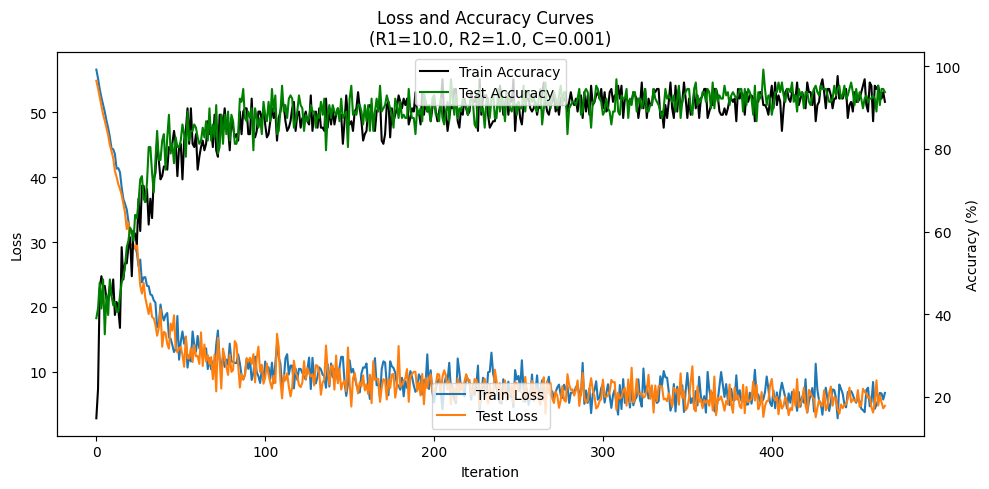

In [ ]:
import matplotlib.pyplot as plt

# Plot Loss and Accuracy Curves
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot Loss curves
ax1.plot(loss_hist, label="Train Loss")
ax1.plot(test_loss_hist, label="Test Loss")
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Loss")

# Create a twin axis for accuracy curves
ax2 = ax1.twinx()

# Plot Accuracy curves
ax2.plot(train_acc_hist, label="Train Accuracy", color="black")
ax2.plot(test_acc_hist, label="Test Accuracy", color="green")
ax2.set_ylabel("Accuracy (%)")

# Create the legend labels
legend_labels_1 = ["Train Loss", "Test Loss"]
legend_labels_2 = ["Train Accuracy", "Test Accuracy"]

# Update the legend with the new labels
ax1.legend(legend_labels_1)
ax2.legend(legend_labels_2)

# Set title and legends
ax1.set_title("Loss and Accuracy Curves  \n(R1={:.1f}, R2={:.1f}, C={:.3f})".format(R1, R2, C))
ax1.legend(loc="lower center")
ax2.legend(loc="upper center")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


In [ ]:
# import matplotlib.pyplot as plt

# # Plot Loss and Accuracy Curves
# fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# # Plot histogram of average loss
# ax1.hist(avg_loss_hist, bins=20, alpha=0.5, color='blue')
# ax1.set_xlabel("Average Loss")
# ax1.set_ylabel("Frequency")
# ax1.legend(["Average Loss"])
# ax1.set_ylim(0, 200)


# # Set title and legends for the first plot
# ax1.set_title("Histogram of Average Loss\n(R1={:.1f}, R2={:.1f}, C={:.3f})".format(R1, R2, C))

# # Plot histogram of average test loss
# ax2.hist(avg_test_loss_hist, bins=20, alpha=0.5, color='red')
# ax2.set_xlabel("Average Test Loss")
# ax2.set_ylabel("Frequency")
# ax2.legend(["Average Test Loss"])
# # ax2.xlim(-5, 470)
# ax2.set_ylim(0, 200)

# # Set title and legends for the second plot
# ax2.set_title("Histogram of Average Test Loss\n(R1={:.1f}, R2={:.1f}, C={:.3f})".format(R1, R2, C))

# # Adjust layout and display the plot
# plt.tight_layout()
# plt.show()


In [ ]:
# # # Plot Loss and Accuracy Curves
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Plot Loss and Accuracy Curves
# fig, ax = plt.subplots(figsize=(10, 8))

# # Plot KDE plot of average loss
# sns.kdeplot(avg_loss_hist, shade=True, color='blue', label='Average Loss')

# # Plot KDE plot of average test loss
# sns.kdeplot(avg_test_loss_hist, shade=True, color='red', label='Average Test Loss')

# # Set labels and title
# ax.set_xlabel("Average Loss")
# ax.set_ylabel("Density")
# ax.set_title("KDE Plot of Average Loss and Average Test Loss \n(R1={:.1f}, R2={:.1f}, C={:.3f})".format(R1, R2, C))

# # Display the legend
# ax.legend()

# # Adjust layout and display the plot
# plt.tight_layout()
# plt.show()


###  The most frequent value in the distribution is around the loss value of 10. In other words, a higher density suggests a higher concentration of data points, while a lower density indicates a sparser distribution. So, the we can see the high concentration of data points around the loss value of 10.

## Saving the outputs

In [ ]:
jk
# # Define the path and file name for saving the model
# save_path = "/path/to/save/folder/model_name.pth"

# # Save the model
# torch.save(net.state_dict(), save_path)
# --------------------------------------------------------------


# Save loss_rec_SAE to file
filename = 'Lapicque_OneHidden_R1_{:.2f}_R2_{:.2f}_C_{:.3f}.pkl'.format(R1, R2, C)

with open(filename, 'wb') as f:
    pickle.dump({'train_loss_rec': loss_hist, 'test_loss_rec': test_loss_hist, 'train_acc_hist': train_acc_hist, 'test_acc_hist': test_acc_hist}, f)

from google.colab import files
files.download(filename)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Load saved files

In [19]:

#--------------------------- Load the files:
import pickle
with open('Lapicque_OneHidden_R1_1.00_R2_1.00_C_0.001.pkl', 'rb') as f:
    data = pickle.load(f)
train_loss_R1_1_0_R2_1_0_C_0_001 = data['train_loss_rec']
test_loss_R1_1_0_R2_1_0_C_0_001 = data['test_loss_rec']
train_acc_hist_R1_1_0_R2_1_0_C_0_001 = data['train_acc_hist']
test_acc_hist_R1_1_0_R2_1_0_C_0_001 = data['test_acc_hist']
# -----------------------------------------------------------------------------
with open('Lapicque_OneHidden_R1_0.50_R2_1.00_C_0.001.pkl', 'rb') as f:
    data = pickle.load(f)
train_loss_R1_0_5_R2_1_0_C_0_001 = data['train_loss_rec']
test_loss_R1_0_5_R2_1_0_C_0_001 = data['test_loss_rec']
train_acc_hist_R1_0_5_R2_1_0_C_0_001 = data['train_acc_hist']
test_acc_hist_R1_0_5_R2_1_0_C_0_001 = data['test_acc_hist']
# -----------------------------------------------------------------------------
with open('Lapicque_OneHidden_R1_0.40_R2_1.00_C_0.001.pkl', 'rb') as f:
    data = pickle.load(f)
train_loss_R1_0_4_R2_1_0_C_0_001 = data['train_loss_rec']
test_loss_R1_0_4_R2_1_0_C_0_001 = data['test_loss_rec']
train_acc_hist_R1_0_4_R2_1_0_C_0_001 = data['train_acc_hist']
test_acc_hist_R1_0_4_R2_1_0_C_0_001 = data['test_acc_hist']
# -----------------------------------------------------------------------------
with open('Lapicque_OneHidden_R1_0.30_R2_1.00_C_0.001.pkl', 'rb') as f:
    data = pickle.load(f)
train_loss_R1_0_3_R2_1_0_C_0_001 = data['train_loss_rec']
test_loss_R1_0_3_R2_1_0_C_0_001 = data['test_loss_rec']
train_acc_hist_R1_0_3_R2_1_0_C_0_001 = data['train_acc_hist']
test_acc_hist_R1_0_3_R2_1_0_C_0_001 = data['test_acc_hist']
# -----------------------------------------------------------------------------
with open('Lapicque_OneHidden_R1_0.20_R2_1.00_C_0.001.pkl', 'rb') as f:
    data = pickle.load(f)
train_loss_R1_0_2_R2_1_0_C_0_001 = data['train_loss_rec']
test_loss_R1_0_2_R2_1_0_C_0_001 = data['test_loss_rec']
train_acc_hist_R1_0_2_R2_1_0_C_0_001 = data['train_acc_hist']
test_acc_hist_R1_0_2_R2_1_0_C_0_001 = data['test_acc_hist']

# -----------------------------------------------------------------------------
with open('Lapicque_OneHidden_R1_0.10_R2_1.00_C_0.001.pkl', 'rb') as f:
    data = pickle.load(f)
train_loss_R1_0_1_R2_1_0_C_0_001 = data['train_loss_rec']
test_loss_R1_0_1_R2_1_0_C_0_001 = data['test_loss_rec']
train_acc_hist_R1_0_1_R2_1_0_C_0_001 = data['train_acc_hist']
test_acc_hist_R1_0_1_R2_1_0_C_0_001 = data['test_acc_hist']


# Comparison of different scenarios:

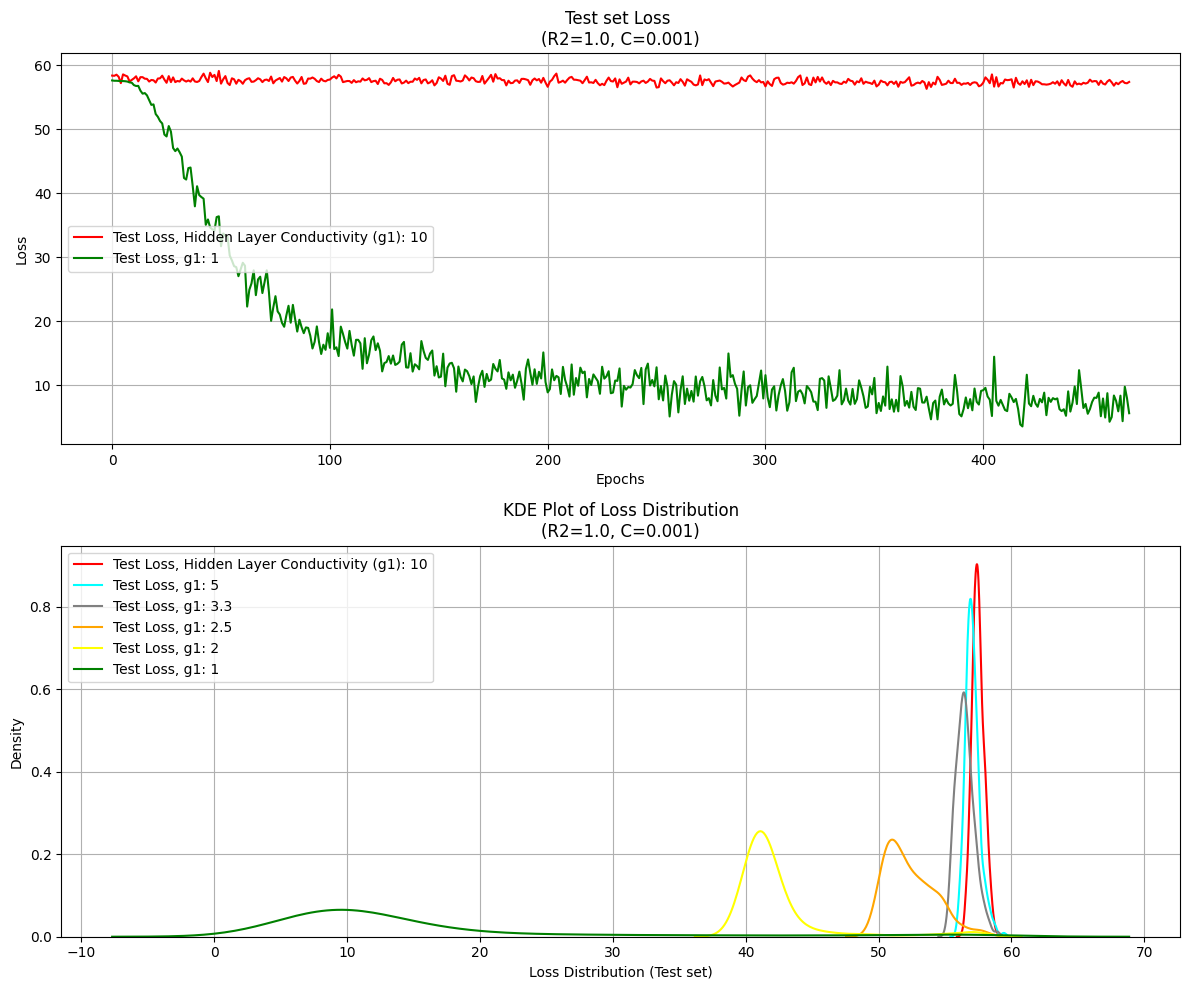

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

R2=1
C=1e-3

# Plot Loss and Accuracy Curves
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

# Plot line plot of test loss
ax1.plot(test_loss_R1_0_1_R2_1_0_C_0_001, color='red', label='Test Loss, Hidden Layer Conductivity (g1): 10')
# # ax1.plot(test_loss_R1_0_1_R2_1_0_C_0_001, color='red', label='with Abnormal Conductivity in Hidden Layer (g1=10)')
# ax1.plot(test_loss_R1_0_2_R2_1_0_C_0_001, color='cyan', label='Test Loss, g1: 5')
# ax1.plot(test_loss_R1_0_3_R2_1_0_C_0_001, color='gray', label='Test Loss, g1: 3.3')
# ax1.plot(test_loss_R1_0_4_R2_1_0_C_0_001, color='orange', label='Test Loss, g1: 2.5')
# ax1.plot(test_loss_R1_0_5_R2_1_0_C_0_001, color='yellow', label='Test Loss, g1: 2')
ax1.plot(test_loss_R1_1_0_R2_1_0_C_0_001, color='green', label='Test Loss, g1: 1')
# ax1.plot(test_loss_R1_1_0_R2_1_0_C_0_001, color='green', label='with Normal Conductivity (g1=1)')

# Set labels and title for the first plot
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Test set Loss \n(R2={:.1f}, C={:.3f})".format(R2, C))
ax1.legend(loc="center left")
ax1.grid()



# Plot KDE plot of average loss
sns.kdeplot(test_loss_R1_0_1_R2_1_0_C_0_001, color='red', label='Test Loss, Hidden Layer Conductivity (g1): 10', ax=ax2)
sns.kdeplot(test_loss_R1_0_2_R2_1_0_C_0_001, color='cyan', label='Test Loss, g1: 5', ax=ax2)
sns.kdeplot(test_loss_R1_0_3_R2_1_0_C_0_001, color='gray', label='Test Loss, g1: 3.3', ax=ax2)
sns.kdeplot(test_loss_R1_0_4_R2_1_0_C_0_001, color='orange', label='Test Loss, g1: 2.5', ax=ax2)
sns.kdeplot(test_loss_R1_0_5_R2_1_0_C_0_001, color='yellow', label='Test Loss, g1: 2', ax=ax2)
sns.kdeplot(test_loss_R1_1_0_R2_1_0_C_0_001, color='green', label='Test Loss, g1: 1', ax=ax2)

# Set labels and title for the first plot
ax2.set_xlabel("Loss Distribution (Test set)")
ax2.set_ylabel("Density")
ax2.set_title("KDE Plot of Loss Distribution\n(R2={:.1f}, C={:.3f})".format(R2, C))
ax2.legend(loc="upper left")
ax2.grid()





# Adjust layout and display the plot
plt.tight_layout()
plt.show()


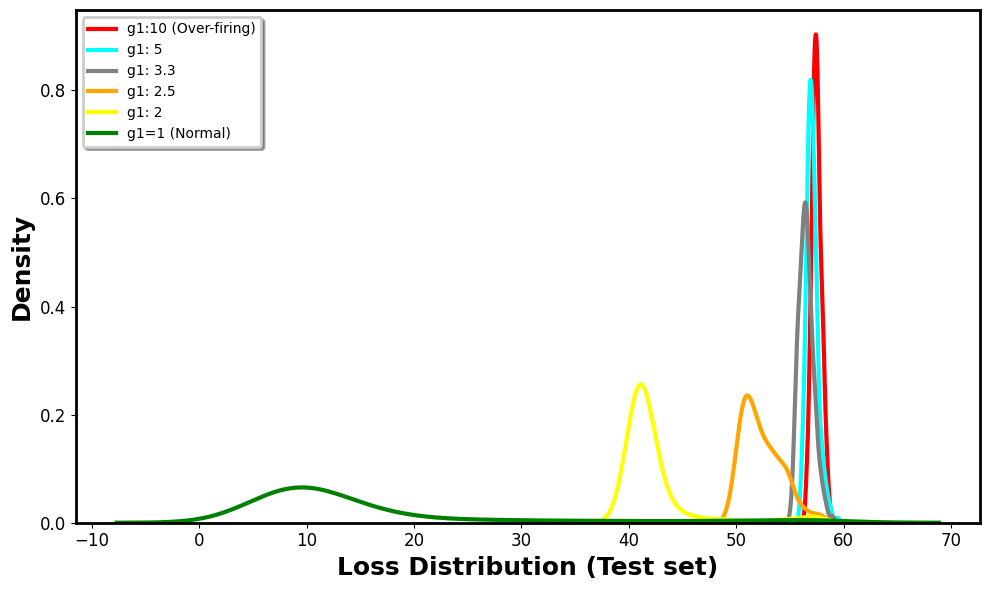

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

R2=1
C=1e-3

# # Plot Loss and Accuracy Curves
# fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

# # Plot line plot of test loss
# ax1.plot(test_loss_R1_0_1_R2_1_0_C_0_001, color='red', label='Test Loss, Hidden Layer Conductivity (g1): 10')
# # # ax1.plot(test_loss_R1_0_1_R2_1_0_C_0_001, color='red', label='with Abnormal Conductivity in Hidden Layer (g1=10)')
# # ax1.plot(test_loss_R1_0_2_R2_1_0_C_0_001, color='cyan', label='Test Loss, g1: 5')
# # ax1.plot(test_loss_R1_0_3_R2_1_0_C_0_001, color='gray', label='Test Loss, g1: 3.3')
# # ax1.plot(test_loss_R1_0_4_R2_1_0_C_0_001, color='orange', label='Test Loss, g1: 2.5')
# # ax1.plot(test_loss_R1_0_5_R2_1_0_C_0_001, color='yellow', label='Test Loss, g1: 2')
# ax1.plot(test_loss_R1_1_0_R2_1_0_C_0_001, color='green', label='Test Loss, g1: 1')
# # ax1.plot(test_loss_R1_1_0_R2_1_0_C_0_001, color='green', label='with Normal Conductivity (g1=1)')

# # Set labels and title for the first plot
# ax1.set_xlabel("Epochs")
# ax1.set_ylabel("Loss")
# ax1.set_title("Test set Loss \n(R2={:.1f}, C={:.3f})".format(R2, C))
# ax1.legend(loc="center left")
# ax1.grid()

plt.figure(figsize=(10, 6))

# Plot KDE plot of average loss
sns.kdeplot(test_loss_R1_0_1_R2_1_0_C_0_001, color='red', label='g1:10 (Over-firing)', linewidth=3)
sns.kdeplot(test_loss_R1_0_2_R2_1_0_C_0_001, color='cyan', label='g1: 5', linewidth=3)
sns.kdeplot(test_loss_R1_0_3_R2_1_0_C_0_001, color='gray', label='g1: 3.3', linewidth=3)
sns.kdeplot(test_loss_R1_0_4_R2_1_0_C_0_001, color='orange', label='g1: 2.5', linewidth=3)
sns.kdeplot(test_loss_R1_0_5_R2_1_0_C_0_001, color='yellow', label='g1: 2', linewidth=3)
sns.kdeplot(test_loss_R1_1_0_R2_1_0_C_0_001, color='green', label='g1=1 (Normal)', linewidth=3)

# sns.kdeplot(test_loss_R1_0_1_R2_1_0_C_0_001, color='red', label='Over-firing', linewidth=3)
# sns.kdeplot(test_loss_R1_1_0_R2_1_0_C_0_001, color='green', label='Normal', linewidth=3)


# Set labels and title for the first plot
font = {'weight': 'bold', 'size': 18}
plt.xlabel("Loss Distribution (Test set)", fontdict=font)
plt.ylabel("Density", fontdict=font)
# plt.title("KDE Plot of Loss Distribution\n(R2={:.1f}, C={:.3f})".format(R2, C))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


ax = plt.gca()
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)

# Set thicker tick width
# ax.tick_params(axis='both', which='both', width=2)

# Create a shaded rectangular background for the legend inside the plot
legend = ax.legend(loc="upper left", frameon=True, fancybox=True, shadow=True)
frame = legend.get_frame()
frame.set_linewidth(2)

# Save the plot
plt.savefig('Fig.7.pdf', format='pdf')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

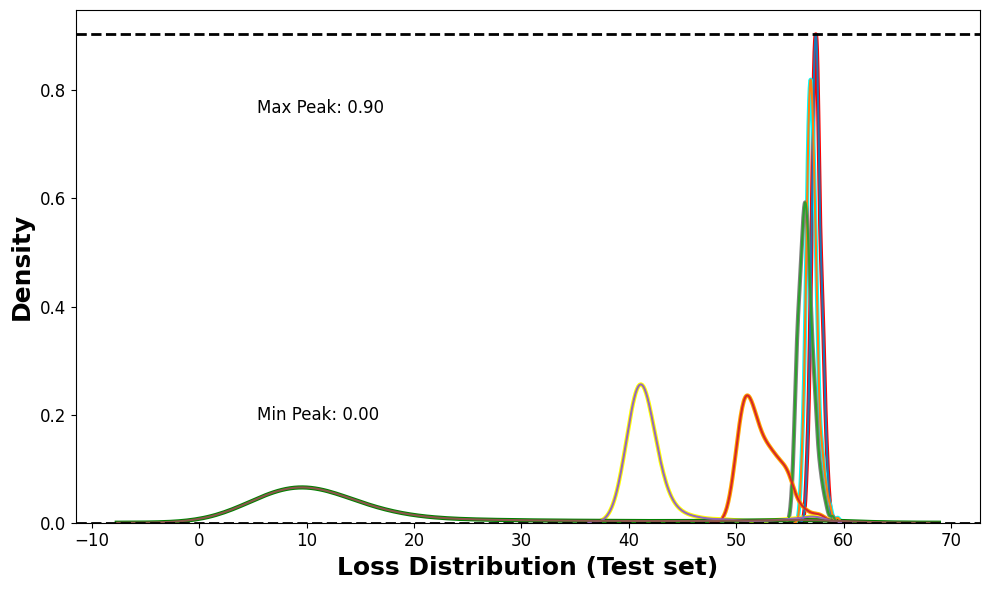

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

R2 = 1
C = 1e-3

plt.figure(figsize=(10, 6))

# Plot KDE plot of average loss
sns.kdeplot(test_loss_R1_0_1_R2_1_0_C_0_001, color='red', label='g1: 10 (Over-firing)', linewidth=3)
sns.kdeplot(test_loss_R1_0_2_R2_1_0_C_0_001, color='cyan', label='g1: 5', linewidth=3)
sns.kdeplot(test_loss_R1_0_3_R2_1_0_C_0_001, color='gray', label='g1: 3.3', linewidth=3)
sns.kdeplot(test_loss_R1_0_4_R2_1_0_C_0_001, color='orange', label='g1: 2.5', linewidth=3)
sns.kdeplot(test_loss_R1_0_5_R2_1_0_C_0_001, color='yellow', label='g1: 2', linewidth=3)
sns.kdeplot(test_loss_R1_1_0_R2_1_0_C_0_001, color='green', label='g1=1 (Normal)', linewidth=3)

# Calculate minimum and maximum density peak values among the curves
density_peaks = [sns.kdeplot(data).get_lines()[0].get_ydata() for data in [
    test_loss_R1_0_1_R2_1_0_C_0_001,
    test_loss_R1_0_2_R2_1_0_C_0_001,
    test_loss_R1_0_3_R2_1_0_C_0_001,
    test_loss_R1_0_4_R2_1_0_C_0_001,
    test_loss_R1_0_5_R2_1_0_C_0_001,
    test_loss_R1_1_0_R2_1_0_C_0_001
]]

min_density_peak = min([min(peaks) for peaks in density_peaks])
max_density_peak = max([max(peaks) for peaks in density_peaks])

# Plot horizontal lines at min and max density peak values
plt.axhline(min_density_peak, color='black', linestyle='dashed', linewidth=2)
plt.axhline(max_density_peak, color='black', linestyle='dashed', linewidth=2)

# Annotate the min and max density peak values
plt.annotate(f'Min Peak: {min_density_peak:.2f}', xy=(0, min_density_peak), xytext=(0.2, 0.2),
             textcoords='axes fraction', fontsize=12, color='black')
plt.annotate(f'Max Peak: {max_density_peak:.2f}', xy=(0, max_density_peak), xytext=(0.2, 0.8),
             textcoords='axes fraction', fontsize=12, color='black')

# Set labels and title for the plot
font = {'weight': 'bold', 'size': 18}
plt.xlabel("Loss Distribution (Test set)", fontdict=font)
plt.ylabel("Density", fontdict=font)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


### KDE plot
Kernel density estimation (KDE) plot: A KDE plot provides a smoothed estimate of the probability density function of the data. It shows the shape of the distribution without binning the data.

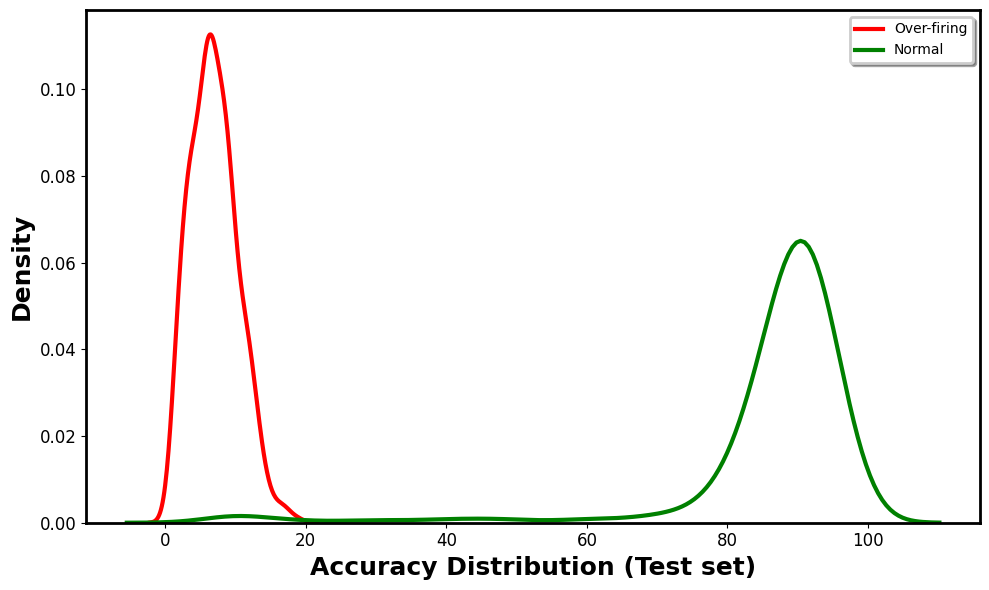

In [ ]:

plt.figure(figsize=(10, 6))



# Plot KDE plot of test accuracy
# sns.kdeplot(test_acc_hist_R1_0_1_R2_1_0_C_0_001, color='red', label='Hidden Layer Conductivity (g1): 10', linewidth=3)
# sns.kdeplot(test_acc_hist_R1_0_2_R2_1_0_C_0_001, color='cyan', label='g1: 5', linewidth=3)
# sns.kdeplot(test_acc_hist_R1_0_3_R2_1_0_C_0_001, color='gray', label='g1: 3.3', linewidth=3)
# sns.kdeplot(test_acc_hist_R1_0_4_R2_1_0_C_0_001, color='orange', label='g1: 2.5', linewidth=3)
# sns.kdeplot(test_acc_hist_R1_0_5_R2_1_0_C_0_001, color='yellow', label='g1: 2', linewidth=3)
# sns.kdeplot(test_acc_hist_R1_1_0_R2_1_0_C_0_001, color='green', label='g1=1 (Normal)', linewidth=3)

sns.kdeplot(test_acc_hist_R1_0_1_R2_1_0_C_0_001, color='red', label='Over-firing', linewidth=3)
sns.kdeplot(test_acc_hist_R1_1_0_R2_1_0_C_0_001, color='green', label='Normal', linewidth=3)


# Set labels and title for the first plot
font = {'weight': 'bold', 'size': 18}
plt.xlabel("Accuracy Distribution (Test set)", fontdict=font)
plt.ylabel("Density", fontdict=font)
# ax2.set_title("KDE Plot of Accuracy Distribution\n(R2={:.1f}, C={:.3f})".format(R2, C))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


ax = plt.gca()
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)

# Set thicker tick width
# ax.tick_params(axis='both', which='both', width=2)

# Create a shaded rectangular background for the legend inside the plot
legend = ax.legend(loc="upper right", frameon=True, fancybox=True, shadow=True)
frame = legend.get_frame()
frame.set_linewidth(2)

# Save the plot
plt.savefig('Fig.8.pdf', format='pdf')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

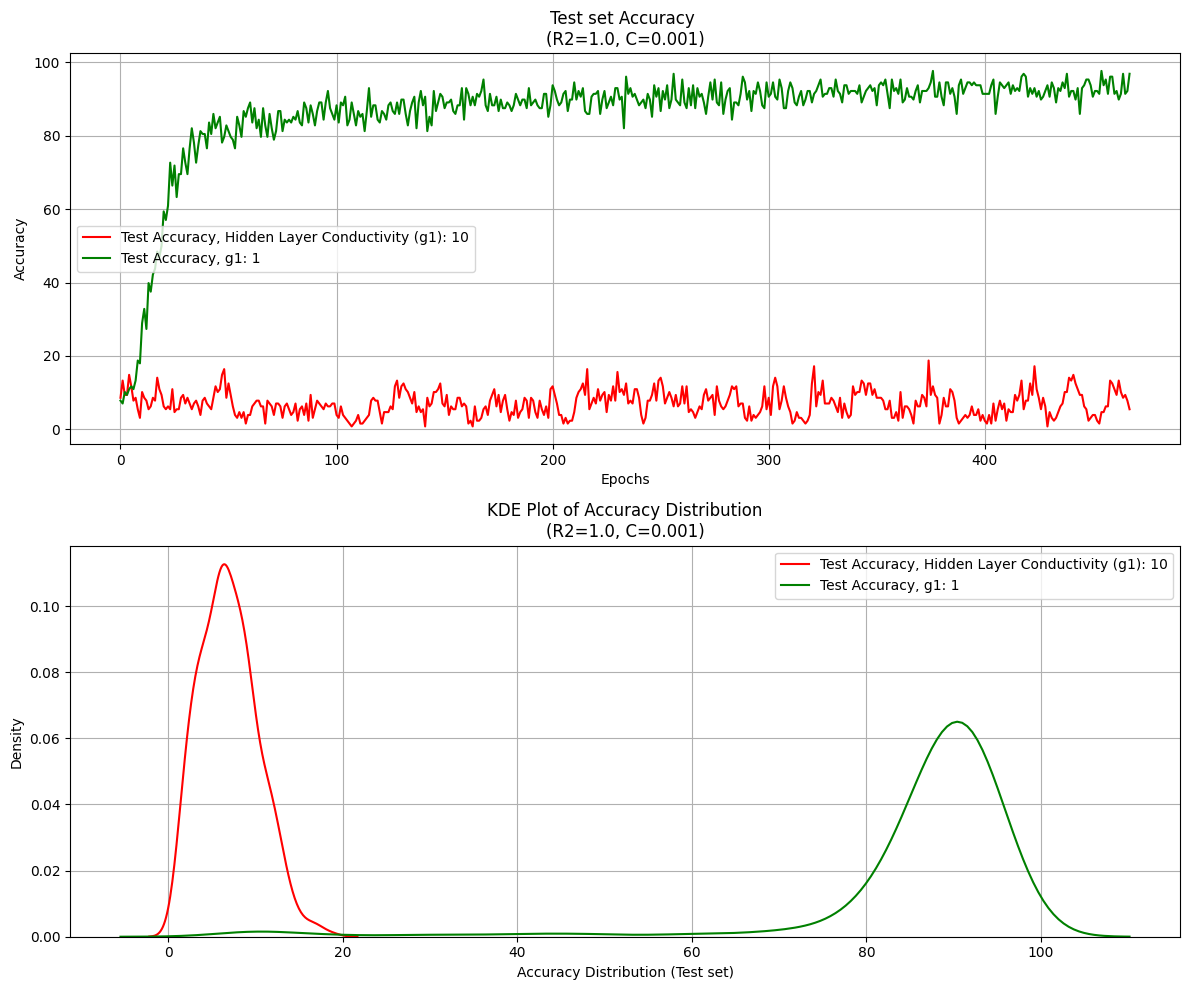

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

R2 = 1
C = 1e-3

# Plot Loss and Accuracy Curves
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))


# Plot line plot of test accuracy
ax1.plot(test_acc_hist_R1_0_1_R2_1_0_C_0_001, color='red', label='Test Accuracy, Hidden Layer Conductivity (g1): 10')
# # ax1.plot(test_acc_hist_R1_0_1_R2_1_0_C_0_001, color='red', label='with Abnormal Conductivity in Hidden Layer (g1=10)')
# ax1.plot(test_acc_hist_R1_0_2_R2_1_0_C_0_001, color='cyan', label='Test Accuracy, (g1): 5')
# ax1.plot(test_acc_hist_R1_0_3_R2_1_0_C_0_001, color='gray', label='Test Accuracy, g1: 3.3')
# ax1.plot(test_acc_hist_R1_0_4_R2_1_0_C_0_001, color='orange', label='Test Accuracy, g1: 2.5')
# ax1.plot(test_acc_hist_R1_0_5_R2_1_0_C_0_001, color='yellow', label='Test Accuracy, g1: 2')
ax1.plot(test_acc_hist_R1_1_0_R2_1_0_C_0_001, color='green', label='Test Accuracy, g1: 1')
# ax1.plot(test_acc_hist_R1_1_0_R2_1_0_C_0_001, color='green', label='with Normal Conductivity (g1=1)')

# Set labels and title for the second plot
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.set_title("Test set Accuracy \n(R2={:.1f}, C={:.3f})".format(R2, C))
ax1.legend(loc="center left")
ax1.grid()








# Plot KDE plot of test accuracy
sns.kdeplot(test_acc_hist_R1_0_1_R2_1_0_C_0_001, color='red', label='Test Accuracy, Hidden Layer Conductivity (g1): 10', ax=ax2)
# sns.kdeplot(test_acc_hist_R1_0_2_R2_1_0_C_0_001, color='cyan', label='Test Accuracy, g1: 5', ax=ax2)
# sns.kdeplot(test_acc_hist_R1_0_3_R2_1_0_C_0_001, color='gray', label='Test Accuracy, g1: 3.3', ax=ax2)
# sns.kdeplot(test_acc_hist_R1_0_4_R2_1_0_C_0_001, color='orange', label='Test Accuracy, g1: 2.5', ax=ax2)
# sns.kdeplot(test_acc_hist_R1_0_5_R2_1_0_C_0_001, color='yellow', label='Test Accuracy, g1: 2', ax=ax2)
sns.kdeplot(test_acc_hist_R1_1_0_R2_1_0_C_0_001, color='green', label='Test Accuracy, g1: 1', ax=ax2)

# Set labels and title for the second plot
ax2.set_xlabel("Accuracy Distribution (Test set)")
ax2.set_ylabel("Density")
ax2.set_title("KDE Plot of Accuracy Distribution\n(R2={:.1f}, C={:.3f})".format(R2, C))
ax2.legend(loc="upper right")
ax2.grid()

# Adjust layout and display the

plt.tight_layout()
plt.show()

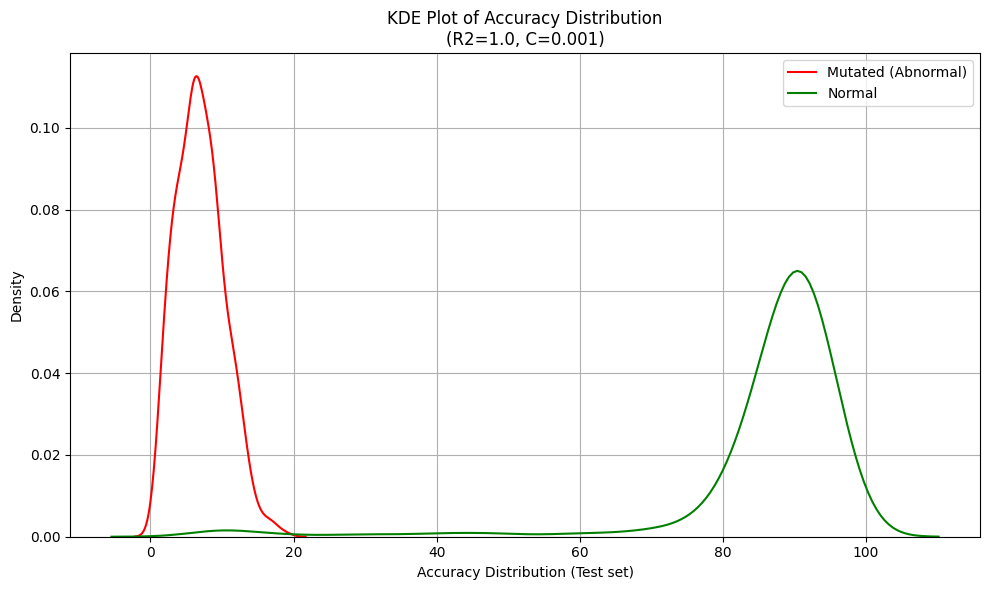

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

R2 = 1
C = 1e-3

# # Plot Loss and Accuracy Curves
# fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))


# # Plot line plot of test accuracy
# ax1.plot(test_acc_hist_R1_0_1_R2_1_0_C_0_001, color='red', label='Test Accuracy, Hidden Layer Conductivity (g1): 10')
# # # ax1.plot(test_acc_hist_R1_0_1_R2_1_0_C_0_001, color='red', label='with Abnormal Conductivity in Hidden Layer (g1=10)')
# # ax1.plot(test_acc_hist_R1_0_2_R2_1_0_C_0_001, color='cyan', label='Test Accuracy, (g1): 5')
# # ax1.plot(test_acc_hist_R1_0_3_R2_1_0_C_0_001, color='gray', label='Test Accuracy, g1: 3.3')
# # ax1.plot(test_acc_hist_R1_0_4_R2_1_0_C_0_001, color='orange', label='Test Accuracy, g1: 2.5')
# # ax1.plot(test_acc_hist_R1_0_5_R2_1_0_C_0_001, color='yellow', label='Test Accuracy, g1: 2')
# ax1.plot(test_acc_hist_R1_1_0_R2_1_0_C_0_001, color='green', label='Test Accuracy, g1: 1')
# # ax1.plot(test_acc_hist_R1_1_0_R2_1_0_C_0_001, color='green', label='with Normal Conductivity (g1=1)')

# # Set labels and title for the second plot
# ax1.set_xlabel("Epochs")
# ax1.set_ylabel("Accuracy")
# ax1.set_title("Test set Accuracy \n(R2={:.1f}, C={:.3f})".format(R2, C))
# ax1.legend(loc="center left")
# ax1.grid()







plt.figure(figsize=(10, 6))

# Plot KDE plot of test accuracy
sns.kdeplot(test_acc_hist_R1_0_1_R2_1_0_C_0_001, color='red', label='Mutated (Abnormal)')
# sns.kdeplot(test_acc_hist_R1_0_2_R2_1_0_C_0_001, color='cyan', label='g1: 5')
# sns.kdeplot(test_acc_hist_R1_0_3_R2_1_0_C_0_001, color='gray', label='g1: 3.3')
# sns.kdeplot(test_acc_hist_R1_0_4_R2_1_0_C_0_001, color='orange', label='g1: 2.5')
# sns.kdeplot(test_acc_hist_R1_0_5_R2_1_0_C_0_001, color='yellow', label='g1: 2')
sns.kdeplot(test_acc_hist_R1_1_0_R2_1_0_C_0_001, color='green', label='Normal')

# Set labels and title for the second plot
plt.xlabel("Accuracy Distribution (Test set)")
plt.ylabel("Density")
plt.title("KDE Plot of Accuracy Distribution\n(R2={:.1f}, C={:.3f})".format(R2, C))
plt.legend(loc="upper right")
plt.grid()

# Adjust layout and display the

plt.tight_layout()
plt.show()

### ECDF plot
An Empirical Cumulative Distribution Function (ECDF) plot shows the cumulative distribution of the data. It displays the proportion of data points that are less than or equal to a given value. This plot helps visualize the overall distribution and provides insights into the spread of the data.

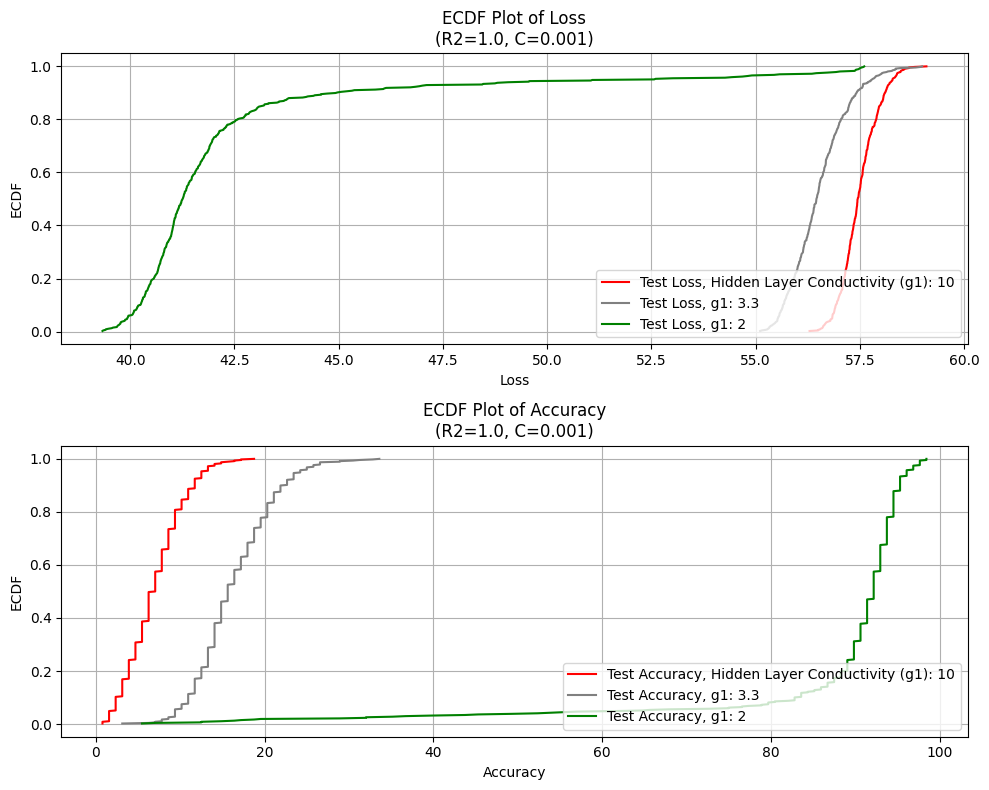

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Plot Loss and Accuracy Curves
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Plot ECDF of average loss
sorted_loss = np.sort(test_loss_R1_0_1_R2_1_0_C_0_001)
y_loss = np.arange(1, len(sorted_loss) + 1) / len(sorted_loss)
ax1.plot(sorted_loss, y_loss, color='red', label='Test Loss, Hidden Layer Conductivity (g1): 10')

sorted_loss = np.sort(test_loss_R1_0_3_R2_1_0_C_0_001)
y_loss = np.arange(1, len(sorted_loss) + 1) / len(sorted_loss)
ax1.plot(sorted_loss, y_loss, color='gray', label='Test Loss, g1: 3.3')

sorted_loss = np.sort(test_loss_R1_0_5_R2_1_0_C_0_001)
y_loss = np.arange(1, len(sorted_loss) + 1) / len(sorted_loss)
ax1.plot(sorted_loss, y_loss, color='green', label='Test Loss, g1: 2')

# Set labels and title for the first plot
ax1.set_xlabel("Loss")
ax1.set_ylabel("ECDF")
ax1.set_title("ECDF Plot of Loss\n(R2={:.1f}, C={:.3f})".format(R2, C))
ax1.legend(loc="lower right")
ax1.grid()

# Plot ECDF of test accuracy
sorted_acc = np.sort(test_acc_hist_R1_0_1_R2_1_0_C_0_001)
y_acc = np.arange(1, len(sorted_acc) + 1) / len(sorted_acc)
ax2.plot(sorted_acc, y_acc, color='red', label='Test Accuracy, Hidden Layer Conductivity (g1): 10')

sorted_acc = np.sort(test_acc_hist_R1_0_3_R2_1_0_C_0_001)
y_acc = np.arange(1, len(sorted_acc) + 1) / len(sorted_acc)
ax2.plot(sorted_acc, y_acc, color='gray', label='Test Accuracy, g1: 3.3')

sorted_acc = np.sort(test_acc_hist_R1_0_5_R2_1_0_C_0_001)
y_acc = np.arange(1, len(sorted_acc) + 1) / len(sorted_acc)
ax2.plot(sorted_acc, y_acc, color='green', label='Test Accuracy, g1: 2')

# Set labels and title for the second plot
ax2.set_xlabel("Accuracy")
ax2.set_ylabel("ECDF")
ax2.set_title("ECDF Plot of Accuracy\n(R2={:.1f}, C={:.3f})".format(R2, C))
ax2.legend(loc="lower right")
ax2.grid()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3544: UserWarning: 35.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3544: UserWarning: 17.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3544: UserWarning: 35.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3544: UserWarning: 17.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3544: UserWarning: 35.0% of the points cannot be plac

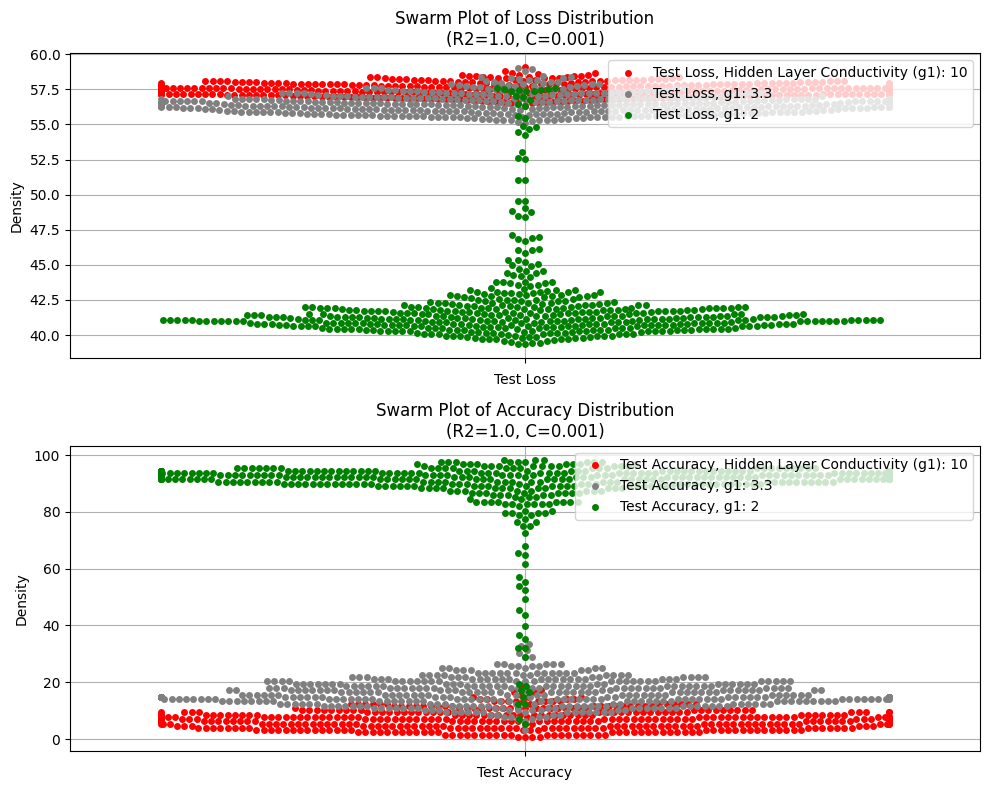

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot Loss and Accuracy Curves
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Plot Swarm plot of average loss
sns.swarmplot(y=test_loss_R1_0_1_R2_1_0_C_0_001, color='red', label='Test Loss, Hidden Layer Conductivity (g1): 10', ax=ax1)
sns.swarmplot(y=test_loss_R1_0_3_R2_1_0_C_0_001, color='gray', label='Test Loss, g1: 3.3', ax=ax1)
sns.swarmplot(y=test_loss_R1_0_5_R2_1_0_C_0_001, color='green', label='Test Loss, g1: 2', ax=ax1)

# Set labels and title for the first plot
ax1.set_xlabel("Test Loss")
ax1.set_ylabel("Density")
ax1.set_title("Swarm Plot of Loss Distribution\n(R2={:.1f}, C={:.3f})".format(R2, C))
ax1.legend(loc="upper right")
ax1.grid()

# Plot Swarm plot of test accuracy
sns.swarmplot(y=test_acc_hist_R1_0_1_R2_1_0_C_0_001, color='red', label='Test Accuracy, Hidden Layer Conductivity (g1): 10', ax=ax2)
sns.swarmplot(y=test_acc_hist_R1_0_3_R2_1_0_C_0_001, color='gray', label='Test Accuracy, g1: 3.3', ax=ax2)
sns.swarmplot(y=test_acc_hist_R1_0_5_R2_1_0_C_0_001, color='green', label='Test Accuracy, g1: 2', ax=ax2)

# Set labels and title for the second plot
ax2.set_xlabel("Test Accuracy")
ax2.set_ylabel("Density")
ax2.set_title("Swarm Plot of Accuracy Distribution\n(R2={:.1f}, C={:.3f})".format(R2, C))
ax2.legend(loc="upper right")
ax2.grid()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


In [ ]:

#     # calculate total accuracy
# _, predicted = test_spk2.sum(dim=0).max(1)
# # total += targets.size(0)
# # correct += (predicted == targets).sum().item()


# print('targets.shape = ', targets.shape)
# print('_.shape = ', _.shape)
# print('predicted.shape = ', predicted.shape)

# #     # calculate total accuracy
# # _, predicted = test_spk.sum(dim=0).max(1)
# # total += targets.size(0)
# # # correct += (predicted == targets).sum().item()

# # print('predicted.shape = ', predicted.shape)
# # print('targets.shape = ',targets.shape)
# # print('test_spk.shape = ', test_spk.shape)
# # print('data.shape = ', data.shape)
# # targets.size(0)

In [ ]:
# total = 0
# correct = 0

# # drop_last switched to False to keep all samples
# test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

# with torch.no_grad():
#   net.eval()
#   for data, targets in test_loader:
#     data = data.to(device)
#     targets = targets.to(device)

#     # # forward pass
#     # test_spk, _ = net(data.view(data.size(0), -1))
#     test_syn, test_spk1, test_mem1, test_spk2, test_mem2 =  net(data.view(data.size(0), -1))

#     # calculate total accuracy
#     _, predicted = test_spk2.sum(dim=0).max(1)
#     total += targets.size(0)
#     correct += (predicted == targets).sum().item()

# print(f"Total correctly classified test set images: {correct}/{total}")
# print(f"Test Set Accuracy: {100 * correct / total:.2f}%" + "\n")
# # print(f"beta1: {np.exp(-time_step/(R1*C)):.3f} , beta2: {np.exp(-time_step/(R2*C)):.3f}" + "\n")


# Rsyn=1
# Rmem=1
# Cmem=5e-3
# Csyn=5e-3
# print(f"alpha: {alpha:.3f} ,  beta: {beta:.3f}")
# print(f"Tau_syn (alpha): {(-(time_step/(math.log(alpha))))*1000:.4f}(ms),  Tau_mem (beta): {(-(time_step/(math.log(beta))))*1000:.4f}(ms)")
# print(f"R_syn (alpha): {(-(time_step/(math.log(alpha)*(Csyn)))):.3f}(Ohm),  R_mem (beta): {(-(time_step/(math.log(beta)*(Cmem)))):.3f}(Ohm) ")
# print(f"g_syn (alpha): {1/(-(time_step/(math.log(alpha)*(Csyn)))):.3f}(S),   g_mem (beta): {1/(-(time_step/(math.log(beta)*(Cmem)))):.3f}(S)" + "\n")

# # print(f"Rsyn: {Rsyn:.1f} , Rmem: {Rmem:.1f}")
# # print(f"Csyn: {Csyn:.3f}, Cmem: {Cmem:.3f}" + "\n")

# print(f"R2 (Lapicque): {R2:.1f}(Ohm)"+ "\n")
# print(f"threshold: {threshold:.1f}")
# print(f"time_step: {time_step:.3f}" + "\n")


# # ////////////////////////////////////// just for printing elapsed time
# def format_time(seconds):
#     if seconds < 300:
#         s = float(seconds)
#         return "%.1f seconds" % (s,)
#     elif seconds < 3600:
#         m = seconds / 60.0
#         return "%.2f minutes" % (m,)
#     else:
#         h = seconds / 3600.0
#         return "%.2f hours" % (h,)

# dt = datetime.datetime.now() - start_time
# t = format_time(dt.total_seconds())

# end_time = datetime.datetime.now()
# dt = datetime.datetime.now() - start_time
# seconds = dt.total_seconds()
# t = format_time(seconds)
# print("time: %s " % (t))
# # /////////////////////////////////////////////////


In [ ]:
# # reshape: A common use case is to flatten a nested array of an unknown number of elements to a 1D array.
# spk1_rec.reshape(num_steps, -1)

# print('num_steps = ', num_steps)

# print('\nspk1_rec.shape = ', spk1_rec.shape)
# print('spk2_rec.shape = ', spk2_rec.shape)

# print('\nspk1_rec.reshape(num_steps, -1).shape = ', spk1_rec.reshape((num_steps), -1).shape)
# print('spk2_rec.reshape(num_steps, -1).shape = ', spk2_rec.reshape(num_steps, -1).shape)

# print('\n(spk2_rec.reshape(num_steps, -1)[:,:].size(1)) = ', (spk2_rec.reshape(num_steps, -1)[:,:].size(1)))

# print('\n(spk1_rec.reshape(num_steps, -1)[:,:(spk2_rec.reshape(num_steps, -1)[:,:].size(1)) = ', spk1_rec.reshape(num_steps, -1)[:,:].shape)

# spk1_rec.reshape(num_steps, -1)[:,:].size(1)

In [ ]:
# fig, ax = plt.subplots(2, figsize=(15,12), sharex=True,
#                         gridspec_kw = {'height_ratios': [1,1]})
# plt.xlabel("Time step")
# # splt.raster(spk1_rec.reshape(num_steps, -1)[:,:(spk2_rec.reshape(num_steps, -1)[:,:].size(1))], ax[0], s = 0.05, c="black")
# # splt.raster(spk1_rec.reshape(num_steps, -1)[:,0:spk1_rec.reshape(num_steps, -1)[:,:].size(1)], ax[0], s = 0.000005, c="black")
# splt.raster(spk1_rec.reshape(num_steps, -1)[:,0:spk1_rec.reshape(num_steps, -1)[:,:].size(1):100], ax[0], s = 0.05, c="black")
# ax[0].set_ylabel(" Hidden L Spikes")
# splt.raster(spk2_rec.reshape(num_steps, -1)[:,0:spk2_rec.reshape(num_steps, -1)[:,:].size(1)], ax[1], s = 0.05, c="blue")
# ax[1].set_ylabel(" Output L Spikes")


In [ ]:
# print('\nmem1_rec.detach().shape = ', mem1_rec.detach().shape)
# print('mem2_rec.detach().shape = ', mem2_rec.detach().shape)

# print('\nmem1_rec.detach().reshape(num_steps, -1).shape = ', mem1_rec.detach().reshape(num_steps, -1).shape)
# print('mem2_rec.detach().reshape(num_steps, -1).shape = ', mem2_rec.detach().reshape(num_steps, -1).shape)


In [ ]:

mem1_rec.detach()[:,:,999:1000].reshape(num_steps, -1)[:,:].shape

In [ ]:


fig, ax = plt.subplots(2, figsize=(10,9), sharex=True,
                        gridspec_kw = {'height_ratios': [1,1]})
plt.xlabel("Time step")


ax[0].plot(mem1_rec.detach().reshape(num_steps, -1)[:,0:128000:128])
ax[0].set_title(' Hidden layer mem1_rec')
ax[0].set_ylabel("Hidden L Membrane Potential ($V_{mem1}$)")

# ax[0].plot(mem2_rec.detach()[:,:,0:1].reshape(num_steps, -1)[:,0:128:16], label='')    # 1st neuron
ax[1].plot(mem2_rec.detach().reshape(num_steps, -1)[:,0:1280:128])
ax[1].set_title('Output Layer mem2_rec')
ax[1].set_ylabel("Output L Membrane Potential ($V_{mem2}$)")


print('\nmem2_rec.detach().reshape(num_steps, -1).shape', mem2_rec.detach().reshape(num_steps, -1).shape)
print('\nmem2_rec.detach().shape', mem2_rec.detach().shape)
print('\nmem1_rec.detach().reshape(num_steps, -1).shape = ', mem1_rec.detach().reshape(num_steps, -1).shape)

# ///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////// Based on Neuron

fig, ax = plt.subplots(2, figsize=(10,9), sharex=True,
                        gridspec_kw = {'height_ratios': [1,1]})
plt.xlabel("Time step")


ax[0].plot(mem1_rec.detach()[:,:,0:1].reshape(num_steps, -1)[:,0:128000:128])
ax[0].set_title(' Hidden layer mem1_rec')
ax[0].set_ylabel("Hidden L Membrane Potential ($V_{mem1}$)")

ax[1].plot(mem2_rec.detach()[:,:,0:1].reshape(num_steps, -1)[:,0:128:16])    # 1st neuron
ax[1].set_title('Neuron(1) Output Layer mem2_rec')
ax[1].set_ylabel("Neuron(1) Output L Membrane Potential ($V_{mem2}$)")



In [ ]:
spk2_rec[:,:].shape


In [ ]:
fig, ax = plt.subplots(2, figsize=(12,6), sharex=True,
                        gridspec_kw = {'height_ratios': [1,1]})
plt.xlabel("Time step")
splt.raster(spk1_rec[:,0], ax[0], s=50, c="red", marker="|")
ax[0].set_title("Hidden layer Spikes([0]) with [|] ")
ax[0].set_ylim([-1, 20])
ax[0].set_ylabel("Neuron")

splt.raster(spk1_rec[:,0], ax[1], s=10, c="red")
ax[1].set_title("Hidden layer Spikes([0] with [.] )")
ax[1].set_ylim([-1, 20])
ax[1].set_ylabel("Neuron")

# ///////////////////////////////////////////////////////////////////////////////////////////////
fig, ax = plt.subplots(2, figsize=(12,6), sharex=True,
                        gridspec_kw = {'height_ratios': [5,1]})
splt.raster(spk1_rec[:,0], ax[0], s=50, c="red", marker="|")
ax[0].set_title("Hidden layer Spikes([0]) with [|] ")
ax[0].set_ylim([-1, 20])
ax[0].set_ylabel("Neuron")

splt.raster(spk2_rec[:,0], ax[1], s=4, c="black")
# ax[1].set_yticks([])
ax[1].set_title("Output layer Spikes([0])")
ax[1].set_ylim([-1, 10])

# splt.raster(spk1_rec[:,127], ax[2],  s=0.001, c="red")
# ax[2].set_title("Hidden layer Spikes([127])")
# splt.raster(spk2_rec[:,127], ax[3], s=400, c="black", marker="|")
# ax[3].set_title("Output layer Spikes([127])")
# ax[3].set_ylim([0, 9])

In [ ]:

# print('\nshape of spk_rec.squeeze(0):  ', np.shape(spk_rec.squeeze(0)))
# print('shape of mem_rec.squeeze(1):  ', np.shape(mem_rec.squeeze(1)))

# Each color shows a neuron output
splt.traces( mem2_rec.squeeze(1) , spk2_rec.squeeze(0), dim=(5,2))
fig = plt.gcf()
fig.set_size_inches(10, 15)

In [ ]:
print('\n   spk2_rec.squeeze(0).shape = ', spk2_rec.squeeze(0).shape,'\n')
splt.traces(spk2_rec.squeeze(0), dim=(5,2))
fig = plt.gcf()
fig.set_size_inches(20, 10)

In [ ]:
print('\n   mem2_rec.shape = ', mem2_rec.shape,'\n')
splt.traces(mem2_rec, dim=(32,4))
fig = plt.gcf()
fig.set_size_inches(18, 16)

In [ ]:
# print('\n   spk1_rec.squeeze(0).shape = ', spk1_rec.squeeze(0).shape,'\n')
# splt.traces(spk1_rec.squeeze(0), dim=(32,4))
# fig = plt.gcf()
# fig.set_size_inches(18, 16)